In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
class Point:
    def __init__(self, 
                 x_pos:float=None, 
                 y_pos:float=None, 
                 is_border:bool=False, 
                 is_airfoil:bool=False, 
                 U_infinity:float=30):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.is_border = is_border
        self.is_airfoil = is_airfoil
        self.U_infinity = U_infinity
        self._preprocess()
    
    def _preprocess(self):
        self.streamline = 0
        self.del_streamline_del_x_value = 0
        self.del_streamline_del_y_value = 0
        self.pressure = 0
        self.absolute_velocity = 0
        self.is_surface_1 = False
        self.is_surface_2 = False
        self.is_surface_3 = False
        self.is_surface_4 = False
        self.g = 9.8
        self.density = 1
        self.bernoulli_result = 10E5/(self.density*self.g)
        
    def set_streamline(self, streamline):
        if self.is_airfoil:
            streamline = 0
        self.streamline = streamline
        
    def get_del_streamline_del_x(self):
        if self.is_border or self.is_airfoil:
            return 0
        return self.del_streamline_del_x_value
    
    def set_del_streamline_del_x(self, stream_line):
        if (not self.is_airfoil) and (not self.is_border):
            self.del_streamline_del_x_value = stream_line
    
    def get_del_streamline_del_y(self):
        if self.is_border:
            return self.U_infinity
        elif self.is_airfoil:
            return 0
        return self.del_streamline_del_y_value
    
    def set_del_streamline_del_y(self, stream_line):
        if (not self.is_airfoil) and (not self.is_border):
            self.del_streamline_del_y_value = stream_line
            
    def calculate_absolute_velocity(self):
        del_in_x = self.get_del_streamline_del_x()
        del_in_y = self.get_del_streamline_del_y()
        self.absolute_velocity = np.sqrt(del_in_x**2 + del_in_y**2)

    
    def calculate_pressure(self):
        if self.is_airfoil:
            return
        self.pressure = self.density*self.g*(
            self.bernoulli_result - (self.absolute_velocity**2)/2*self.g)
        
    
            
p = Point()

In [195]:
class Mesh:
    def __init__(self, delta:float = 0.01, 
                    rotation_angle_in_degrees:float=0, 
                    U_infinity:float=30, 
                    max_num_of_iterations:float=10E5):
        self.delta = delta
        self.lambda_value = 1.85
        self.tolerance = 0.01
        self.rotation_angle_in_degrees = rotation_angle_in_degrees
        self.rotation_angle = rotation_angle_in_degrees*np.pi/180
        self.U_infinity = U_infinity
        self.max_num_of_iterations = max_num_of_iterations
        self._preprocess()
    
    def _preprocess(self):
        mesh_width = 11
        mesh_heigth = 8
        self.airfoil_width = 1
        self.airfoil_height = 4
        self.num_of_iterations = 0
        self.rotation_matrix = np.array([[-np.sin(self.rotation_angle), np.cos(self.rotation_angle)],
                                         [-np.cos(self.rotation_angle), -np.sin(self.rotation_angle)]])
        
        self.airfoil_center = np.array([mesh_width/2, mesh_heigth/2])
        new_system_center = self.rotation_matrix@self.airfoil_center        
        self.p1 = new_system_center + np.array([self.airfoil_width/2, self.airfoil_height/2]) 
        self.p2 = new_system_center + np.array([-self.airfoil_width/2, -self.airfoil_height/2]) 
        
        self.num_of_cols = int(mesh_width/self.delta)    
        self.num_of_rows = int(mesh_heigth/self.delta)    
        self.mesh = [[None]*self.num_of_cols for _ in range(self.num_of_rows)]
        for col_id in range(self.num_of_cols):
            for row_id in range(self.num_of_rows):
                new_x = (self.delta/2) * (2*col_id+1)
                new_y = (self.delta/2) * (2*row_id + 1)
                new_point = Point(x_pos = new_x, y_pos = new_y, U_infinity=self.U_infinity)
                is_airfoil = self.is_in_airfoil(new_point)
                new_point.is_airfoil = is_airfoil
                if (row_id == 0 or 
                    col_id == 0 or 
                    row_id == (self.num_of_rows-1) or 
                    col_id == (self.num_of_cols-1)):
                    new_point.is_border = True
                self.mesh[row_id][col_id] = new_point
                
        for col_id in range(1,self.num_of_cols-1):
            for row_id in range(1,self.num_of_rows-1):
                self.center_point = self.mesh[row_id][col_id]
                if not self.center_point.is_airfoil:
                    self.left_point = self.mesh[row_id][col_id-1]
                    self.right_point = self.mesh[row_id][col_id+1]
                    self.upper_point = self.mesh[row_id-1][col_id]
                    self.lower_point = self.mesh[row_id+1][col_id]
                    if (self.left_point.is_airfoil
                        or self.right_point.is_airfoil
                        or self.upper_point.is_airfoil
                        or self.lower_point.is_airfoil):
                        self.is_in_surface(row_id, col_id)
    
    def is_in_surface(self, row_id, col_id):
        point_position = np.array([self.center_point.x_pos, self.center_point.y_pos]) - self.airfoil_center
        point_position_in_new_system = self.rotation_matrix@point_position
        point_position_in_new_system = point_position_in_new_system*(1+self.delta)
        new_x = point_position_in_new_system[0]
        new_y = point_position_in_new_system[1]
        if new_x >= (self.airfoil_width/2):
            self.mesh[row_id][col_id].is_surface_1 = True
        elif new_x <= -(self.airfoil_width/2):
            self.mesh[row_id][col_id].is_surface_3 = True
        elif new_y >= (self.airfoil_height/2):
            self.mesh[row_id][col_id].is_surface_4 = True
        elif new_y <= -(self.airfoil_height/2):
            self.mesh[row_id][col_id].is_surface_2 = True
             
    
    def is_in_airfoil(self, point):
        x_pos = point.x_pos
        y_pos = point.y_pos
        position_in_new_system = self.rotation_matrix@np.array([x_pos, y_pos])
        new_x, new_y = position_in_new_system[0], position_in_new_system[1]
        in_x = (self.p1[0]>new_x and self.p2[0]<new_x)
        in_y = (self.p1[1]>new_y and self.p2[1]<new_y)
        if in_x and in_y:
            return True
        return False
        
    def get_parameter_value(self, 
                            streamline:bool=False, 
                            velocity:bool=False, 
                            pressure:bool=False):  
        mesh = [[None]*self.num_of_cols for _ in range(self.num_of_rows)]
        for row_id in range(self.num_of_rows): 
            for col_id in range(self.num_of_cols):   
                if streamline:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].streamline
                elif velocity:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].absolute_velocity
                elif pressure:
                    mesh[row_id][col_id] = self.mesh[row_id][col_id].pressure
                else:
                    raise Exception("Must set a parameter to get value")
        return mesh
        
    def apply_overelaxing(self, old_value, calculated_value):
        new_value = self.lambda_value*calculated_value + (1-self.lambda_value)*old_value
        try:
            error = np.absolute((new_value-old_value)/new_value)
        except:
            return 0, 0
        return new_value, error
    
    def calculate_point_is_border(self):
        calculated_value = 0            
        if self.upper_point is None:
            if self.left_point is None: 
                calculated_value = (2*self.right_point.streamline + 
                                    2*self.lower_point.streamline + 
                                    2*self.delta*self.U_infinity)/4

            elif self.right_point is None: 
                calculated_value = (2*self.left_point.streamline + 
                                    2*self.lower_point.streamline + 
                                    2*self.delta*self.U_infinity)/4
                
            else:
                calculated_value = (self.left_point.streamline +
                                    self.right_point.streamline +
                                    2*self.lower_point.streamline + 
                                    2*self.delta*self.U_infinity)/4
        elif self.lower_point is None:
            if self.left_point is None: 
                calculated_value = (2*self.right_point.streamline + 
                                    2*self.upper_point.streamline 
                                    -2*self.delta*self.U_infinity)/4
            elif self.right_point is None: 
                calculated_value = (2*self.left_point.streamline + 
                                    2*self.upper_point.streamline
                                    -2*self.delta*self.U_infinity)/4
            else:
                calculated_value = (self.left_point.streamline +
                                    self.right_point.streamline +
                                    2*self.upper_point.streamline
                                    -2*self.delta*self.U_infinity)/4
        elif self.left_point is None and ((self.upper_point is not None) 
                                          and (self.lower_point is not None)):
            calculated_value = (2*self.right_point.streamline 
                                +self.lower_point.streamline 
                                + self.upper_point.streamline)/4
        elif self.right_point is None and ((self.upper_point is not None) 
                                           and (self.lower_point is not None)):
            calculated_value = (2*self.left_point.streamline 
                                +self.lower_point.streamline 
                                + self.upper_point.streamline)/4
        
        return calculated_value
    
    def iter_streamline(self, row_id, col_id):
        if row_id == 0:
            self.upper_point = None
        else: 
            self.upper_point = self.mesh[row_id-1][col_id]
        if row_id == (self.num_of_rows-1):
            self.lower_point = None
        else:
            self.lower_point = self.mesh[row_id+1][col_id]
            
        if col_id == 0:
            self.left_point = None
        else:
            self.left_point = self.mesh[row_id][col_id-1]
        if col_id == (self.num_of_cols-1):
            self.right_point = None
        else:
            self.right_point = self.mesh[row_id][col_id+1]
        
        center_point = self.mesh[row_id][col_id]
        old_streamline_value = center_point.streamline
        if center_point.is_airfoil: 
            return 0
        elif center_point.is_border:
            calculated_streamline_value = self.calculate_point_is_border()        
        else:            
            calculated_streamline_value = (self.upper_point.streamline + 
                                self.left_point.streamline + 
                                self.lower_point.streamline + 
                                self.right_point.streamline)/4
            #print('c',calculated_streamline_value)
        new_streamline_value, error = self.apply_overelaxing(
                        old_streamline_value,calculated_streamline_value)
        (self.mesh[row_id][col_id]).set_streamline(new_streamline_value)
        
        return error
    

    def calculate_derivates(self, row_id, col_id):
        center_point = self.mesh[row_id][col_id]
        if center_point.is_border or center_point.is_airfoil:
            self.mesh[row_id][col_id].calculate_absolute_velocity()
            self.mesh[row_id][col_id].calculate_pressure()
            return
        del_in_x =(self.right_point.streamline - self.left_point.streamline)/(2*self.delta)
        del_in_y = (self.upper_point.streamline - self.lower_point.streamline)/(2*self.delta)
        self.mesh[row_id][col_id].set_del_streamline_del_x(del_in_x)
        self.mesh[row_id][col_id].set_del_streamline_del_y(del_in_y)
        self.mesh[row_id][col_id].calculate_absolute_velocity()
        self.mesh[row_id][col_id].calculate_pressure()
    
    def calculate_velocity_and_pressure(self):
        for row_id in range(self.num_of_rows): 
            for col_id in range(self.num_of_cols):   
                if row_id == 0:
                    self.upper_point = None
                else: 
                    self.upper_point = self.mesh[row_id-1][col_id]
                if row_id == (self.num_of_rows-1):
                    self.lower_point = None
                else:
                    self.lower_point = self.mesh[row_id+1][col_id]
                    
                if col_id == 0:
                    self.left_point = None
                else:
                    self.left_point = self.mesh[row_id][col_id-1]
                if col_id == (self.num_of_cols-1):
                    self.right_point = None
                else:
                    self.right_point = self.mesh[row_id][col_id+1]
                self.calculate_derivates(row_id, col_id)
                    
        
    def simul(self):
        max_error = np.inf 
        while((max_error > self.tolerance) and (self.num_of_iterations<self.max_num_of_iterations)): 
            temp_error = 0  
            for row_id in range(self.num_of_rows): 
                for col_id in range(self.num_of_cols):   
                    
                    #print('\n',row_id,col_id)
                    error = self.iter_streamline(row_id,col_id)
                    if error > temp_error:
                        temp_error = error
                    #print((self.mesh[row_id][col_id]).streamline, error)
            self.num_of_iterations+=1
            max_error = temp_error
            print(f"Iteration: {self.num_of_iterations} - Max Error: {round(max_error,5)}")
        self.calculate_velocity_and_pressure()
        
    def plot_mesh(self): 
        mesh = [[None]*self.num_of_cols for _ in range(self.num_of_rows)]
        for c in range(self.num_of_cols):
            for r in range(self.num_of_rows):
                point = self.mesh[r][c]
                mesh[r][c] = not point.is_airfoil
        plt.imshow(mesh, cmap='gray', interpolation='nearest')
        plt.title(f'Posição do Aerofólio \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()
    
    def plot_streamline(self):
        mesh_values = self.get_parameter_value(streamline=True)  
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='coolwarm', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        nonzero_values = mesh_values[mesh_values != 0]
        levels = np.percentile(nonzero_values, np.linspace(0, 100, num=30))  
        plt.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                    extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))
        plt.title(f"Linha de Corrente para o Escoamento \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus")

        plt.axis('off')
        plt.show() 
    
    def plot_velocities(self, plot_contour:bool=False):
        mesh_values = self.get_parameter_value(velocity=True)
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='turbo', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        if plot_contour:
            nonzero_values = mesh_values[mesh_values != 0]
            levels = np.percentile(nonzero_values, np.linspace(0, 100, num=10))  
            plt.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                        extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))
        plt.title(f'Velocidade Absoluta (m/s)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()
        
    def plot_pressure(self, plot_contour:bool=False):
        mesh_values = self.get_parameter_value(pressure=True)
        mesh_values = np.array(mesh_values)
        mask = np.zeros_like(mesh_values, dtype=bool)
        mask[mesh_values == 0] = True
        sns.heatmap(mesh_values, annot=False, cmap='Spectral', linewidths=0, mask=mask, cbar_kws={'extend': 'both'})
        if plot_contour:
            nonzero_values = mesh_values[mesh_values != 0]
            levels = np.percentile(nonzero_values, np.linspace(0, 100, num=10))  
            plt.contour(mesh_values, levels=levels, colors='k', linestyles='solid', linewidths=2, alpha=0.7,
                        extent=(0, mesh_values.shape[1], 0, mesh_values.shape[0]))
        plt.title(f'Pressão (Pa)\n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
        plt.axis('off')
        plt.show()
        

        
        
m = Mesh(rotation_angle_in_degrees=90, delta = 0.01)

mesh = m.mesh
#m.plot_mesh()
m.simul()
#m.plot_streamline()
#m.plot_velocities(plot_contour=True)
#m.plot_pressure(plot_contour=True)
#

Iteration: 1 - Max Error: 1.0
Iteration: 2 - Max Error: 1.0
Iteration: 3 - Max Error: 1.0
Iteration: 4 - Max Error: 1.0
Iteration: 5 - Max Error: 1.0
Iteration: 6 - Max Error: 1.0


KeyboardInterrupt: 

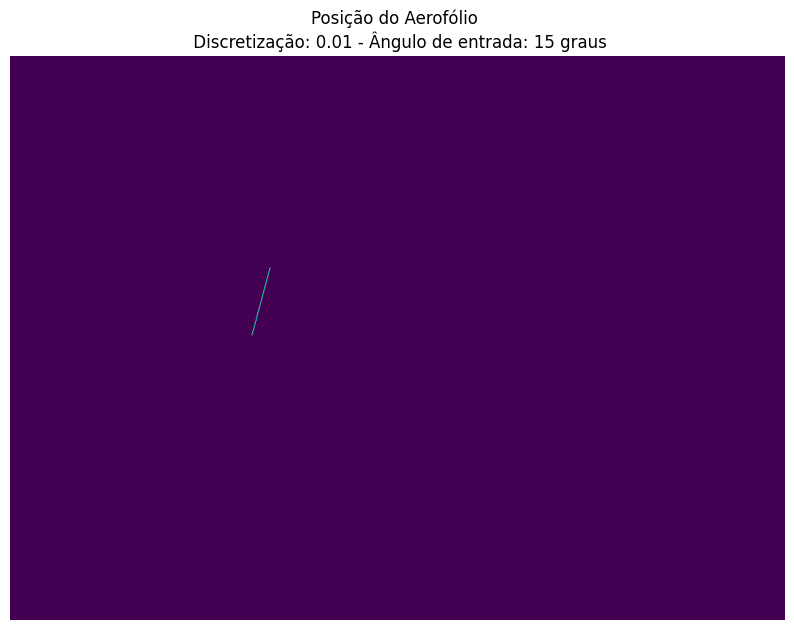

In [193]:
def plot_mesh(self): 
    
    mesh = [[None]*self.num_of_cols for _ in range(self.num_of_rows)]
    for c in range(self.num_of_cols):
        for r in range(self.num_of_rows):
            point = self.mesh[r][c]
            if point.is_surface_4:
                mesh[r][c] = 1
            #elif point.is_surface_2:
            #    mesh[r][c] = 2
            #elif point.is_surface_3:
            #    mesh[r][c] = 3
            #elif point.is_surface_4:
            #    mesh[r][c] = 4
            else: 
                mesh[r][c] = 0
    plt.figure(figsize=(10, 8))
    plt.imshow(mesh)
    plt.title(f'Posição do Aerofólio \n Discretização: {self.delta} - Ângulo de entrada: {self.rotation_angle_in_degrees} graus')
    plt.axis('off')
    plt.show()        
        
        
plot_mesh(m)

In [ ]:
#36 min - 90 deg - 0.02 de disc - 4786 iterations

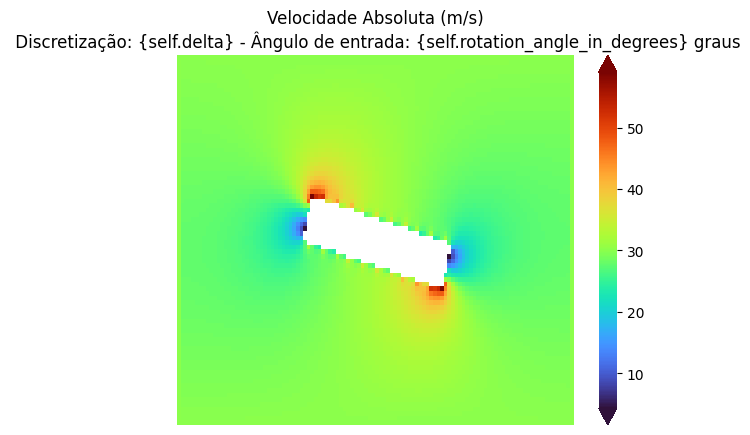

In [5]:
m.plot_velocities()

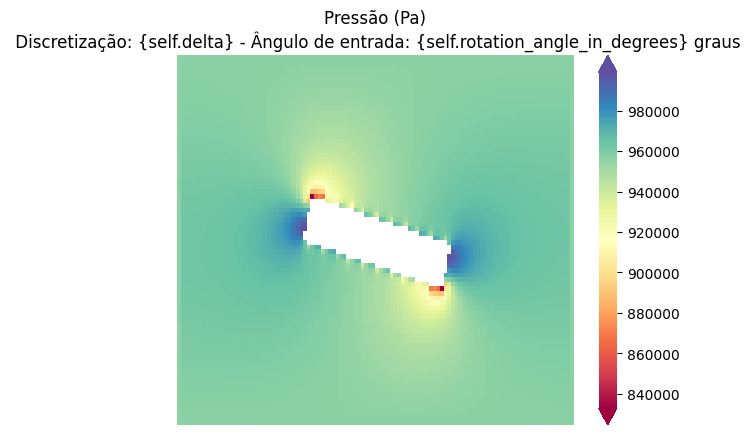

In [6]:
m.plot_pressure()